### <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [2]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms, models

import time

from typing import Iterable
import itertools

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
import seaborn as sns


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

In [3]:
class KenyanFood13Dataset(Dataset):
    """
    Custom Dataset for loading images and labels for the KenyanFood13 challenge.
    This class reads a CSV file with columns 'id' and 'class', and loads images stored as '<id>.jpg'
    in the specified image root directory. It also supports optional image resizing and transformations.
    The train flag is used to split the full dataset into 80% training and 20% validation.
    """
    
    def __init__(self, csv_file, image_root, train=True, image_shape=None, transform=None):
        """
        Initialization method.
        
        Parameters:
        
        csv_file (str): Path to the CSV file containing image ids and class labels.
        
        image_root (str): Directory where image files are stored. Images are expected to be named as '<id>.jpg'.
        
        train (bool): If True, returns 80% of the data for training; if False, returns 20% for validation.
        
        image_shape (int or tuple or list): [optional] If provided, image will be resized to the given shape.
                                            If an integer is provided, images are resized to (image_shape, image_shape).
                                            If a tuple/list is provided with one value, it is converted to square dimensions;
                                            otherwise, the tuple is used as is.
                                            
        transform (callable): Transformation function to be applied on the PIL image.
        """
        # Read the CSV file containing the image ids and their class labels
        self.data = pd.read_csv(csv_file)
        self.image_root = image_root
        self.train = train
        self.transform = transform
        
        # Process image_shape parameter
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            elif isinstance(image_shape, (tuple, list)):
                assert len(image_shape) in [1, 2], 'Invalid image_shape tuple/list size'
                self.image_shape = (image_shape[0], image_shape[0]) if len(image_shape) == 1 else image_shape
            else:
                raise NotImplementedError("image_shape must be an int, tuple, or list")
        else:
            self.image_shape = None
        
        # Create a mapping from class name to integer label
        self.classes = sorted(self.data['class'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        # Build the list of samples (each sample is a tuple of image path and numeric label)
        full_samples = []
        for _, row in self.data.iterrows():
            img_id = row['id']
            label_str = row['class']
            label = self.class_to_idx[label_str]
            img_path = os.path.join(self.image_root, f"{img_id}.jpg")
            full_samples.append((img_path, label))
        
        # Shuffle the full sample list with a fixed seed for reproducibility and split into train/validation.
        random.seed(42)
        random.shuffle(full_samples)
        n_train = int(0.8 * len(full_samples))
        if self.train:
            self.samples = full_samples[:n_train]
        else:
            self.samples = full_samples[n_train:]
    
    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        For the given index, returns the processed image and its label.
        
        Parameters:
            idx (int): Index of the sample to retrieve.
            
        Returns:
            image: Processed image.
            target (int): Numeric label for the image.
        """
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Resize image if image_shape is specified
        if self.image_shape is not None:
            image = TF.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def class_name(self, label):
        """
        Gets the class name corresponding to a numeric label.
        
        Parameters:
            label (int): Numeric label.
        
        Returns:
            str: Class name.
        """
        return self.classes[label]
    
    

In [4]:
def split_and_copy():
    # Read the train.csv file
    csv_file_path = 'train.csv'
    df = pd.read_csv(csv_file_path)

    # Define directories for training and validation datasets
    train_dir = 'training'
    val_dir = 'validation'

    # Create directories for training and validation datasets, and subdirectories for each class
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    classes = df['class'].unique()
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Split the data into training and validation sets (80:20 ratio)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

    # Function to copy images to their respective directories
    def copy_images(df, src_dir, dest_dir):
        for _, row in df.iterrows():
            img_id = row['id']
            img_class = row['class']
            dest_path = os.path.join(dest_dir, img_class, f'{img_id}.jpg')
            src_path = os.path.join(src_dir, f'{img_id}.jpg')
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)

    # Source directory containing the images
    src_dir = 'images/images'

    # Copy images to training and validation directories
    copy_images(train_df, src_dir, train_dir)
    copy_images(val_df, src_dir, val_dir)

    print('Training and validation datasets split and images copied successfully.')

# Check if training and validation folders exist;
# if they exist, skip the steps, otherwise run the corresponding function.
if os.path.exists('training') and os.path.exists('validation'):
    print("Folders exist, skipping data split and copy step.")
else:
    split_and_copy()

Folders exist, skipping data split and copy step.


In [5]:

train_data = datasets.ImageFolder("training")
validation_data = datasets.ImageFolder("validation")
print(train_data.class_to_idx)

{'bhaji': 0, 'chapati': 1, 'githeri': 2, 'kachumbari': 3, 'kukuchoma': 4, 'mandazi': 5, 'masalachips': 6, 'matoke': 7, 'mukimo': 8, 'nyamachoma': 9, 'pilau': 10, 'sukumawiki': 11, 'ugali': 12}


In [6]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

def get_mean_std():
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    
    return mean, std

def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

def data_augmentation_preprocess(mean, std):
    """
    Defines the data augmentation and preprocessing pipeline.

    Args:
        mean (list): Mean values for normalization.
        std (list): Standard deviation values for normalization.

    Returns:
        torchvision.transforms.Compose: The composed transformations.
    """
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

def get_data(batch_size, data_root, num_workers=4, data_augmentation=True):
    
    train_data_path = os.path.join(data_root, 'training')
       
    # mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    mean, std = get_mean_std()
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              common_transforms, # use common transforms for validation
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader
    

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 64  # amount of data to pass through the network at each forward-backward iteration  
    epochs_count: int = 100  # number of times the whole dataset will be passed through the network 
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  
    log_interval: int = 1  # how many batches to wait before logging training status  
    test_interval: int = 1  
    data_root: str = './'
    csv_file: str = './train.csv'
    num_workers: int = 2  # number of concurrent processes using to prepare data  
    device: str = 'cuda'  
    lr_scheduler_patience: int = 5     # Patience (in epochs) for ReduceLROnPlateau scheduler
    lr_scheduler_factor: float = 0.3   # LR reduction factor when plateauing
    early_stopping_patience: int = 10  # Patience (in epochs) for early stopping
    



In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [10]:
# food_classes = ['Ugali', 'Chapati', 'Mukimo', 'Matoke', 'Kachumbari', 'Sukuma Wiki', 'Nyama Choma', 'Githeri', 'Mandazi', 'Pilau', 'Kebab', 'Samaki', 'Wali']
dataset = KenyanFood13Dataset(TrainingConfiguration.csv_file, TrainingConfiguration.data_root, train=False, image_shape=224)
food_classes = dataset.classes
food_classes

['bhaji',
 'chapati',
 'githeri',
 'kachumbari',
 'kukuchoma',
 'mandazi',
 'masalachips',
 'matoke',
 'mukimo',
 'nyamachoma',
 'pilau',
 'sukumawiki',
 'ugali']

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [11]:
def prediction(model, device, batch_input, max_prob=True):
    """
    get prediction for batch inputs
    """
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # get probability score using softmax
    prob = F.softmax(output, dim=1)
    
    if max_prob:
        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    else:
        pred_prob = prob.data
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [12]:
def get_target_and_prob(model, dataloader, device):
    """
    get targets and prediction probabilities
    """
    
    pred_prob = []
    targets = []
    
    for _, (data, target) in enumerate(dataloader):
        
        _, prob = prediction(model, device, data, max_prob=False)
        
        pred_prob.append(prob)
        
        target = target.numpy()
        targets.append(target)
        
    targets = np.concatenate(targets)
    targets = targets.astype(int)
    pred_prob = np.concatenate(pred_prob, axis=0)
    
    return targets, pred_prob


def plot_confusion_matrix(model, data_root, mean, std, batch_size=32):
    # Set device and move model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    # Create dataset and dataloader with common transforms
    test_dataset = datasets.ImageFolder(
        root=data_root,
        transform=image_common_transforms(mean, std)
    )
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    all_preds = []
    all_targets = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [13]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [14]:
import torch.nn.functional as F
from tqdm import tqdm

def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_correct_predictions = 0
    # Iterate over test_loader with a tqdm progress bar.
    for data, target in tqdm(test_loader, desc="Validation", leave=False):
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        # print("Data device:", data.device)
        # print("Target device:", target.device)
        
        with torch.no_grad():
            output = model(data)
        
        # Accumulate loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Get predictions from probabilities
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1]
        
        count_correct_predictions += pred.cpu().eq(indx_target).sum().item()

    # Average loss over the number of mini-batches
    test_loss = test_loss / len(test_loader)
    
    # Compute accuracy over the entire dataset
    accuracy = 100. * count_correct_predictions / len(test_loader.dataset)
    
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, count_correct_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy / 100.0

In [15]:
def save_model(model, device, model_dir='models', model_file_name='final_kenyaFood_classifier.pt'):
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu. 
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return model_path                                 

def load_model(model, model_dir='models', model_file_name='final_kenyaFood_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [16]:
def main(model, optimizer, scheduler=None, early_stopping=None, 
         system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), 
         data_augmentation=True):
    
    print("Step 1: Setting up system configuration...")
    setup_system(system_configuration)

    print("Step 2: Initializing training parameters (batch size, num_workers, epochs)...")
    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    print("Step 3: Selecting device...")
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4
    print("  Device selected:", device)

    # Move model to the selected device
    model.to(device)
    print("Model device:", next(model.parameters()).device)

    print("Step 4: Creating data loaders...")
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    print("Data loaders created.")
    

    print("Step 5: Updating training configuration with system-adjusted parameters...")
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    print("Step 6: Sending model to device...")
    model.to(training_configuration.device)
    print("Model device after update:", next(model.parameters()).device)

    best_loss = float('inf')
    
    # Arrays to track epoch train/test loss and accuracy
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    print("Step 7: Performing initial validation...")
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss: {:.6f}, Initial Test Accuracy: {:.3f}%".format(
        init_val_loss, init_val_accuracy * 100))
    
    t_begin = time.time()
    print("Step 8: Starting training loop for {} epochs...".format(training_configuration.epochs_count))
    for epoch in range(training_configuration.epochs_count):
        print("\nEpoch [{}/{}] Start".format(epoch + 1, training_configuration.epochs_count))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, train_loss)
        epoch_train_acc = np.append(epoch_train_acc, train_acc)
        
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ETA {:.2f}s".format(
            elapsed_time, speed_epoch, speed_batch, eta))

        # Validate at set interval
        if epoch % training_configuration.test_interval == 0:
            print("Step 9: Running validation for epoch {}...".format(epoch + 1))
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, current_loss)
            epoch_test_acc = np.append(epoch_test_acc, current_accuracy)
            
            # Early stopping check using validation loss
            if early_stopping is not None:
                early_stopping(current_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    break

            # Scheduler step/update; prefer validation loss for ReduceLROnPlateau
            if scheduler is not None:
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(current_loss)
                    print("Bad Epochs: {}".format(scheduler.num_bad_epochs))
                    print("Last LR = {}".format(scheduler._last_lr))
                else:
                    scheduler.step()

            # Save the model if loss has improved
            if current_loss < best_loss:
                best_loss = current_loss
                print("Model Improved. Saving the Model...\n")
                save_model(model, device=training_configuration.device)
        
    print("\nStep 10: Training complete.")
    print("Total time: {:.2f}s, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss), flush=True)
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [17]:
def pretrained_resnet18(transfer_learning=True, num_class=13):
    resnet = models.resnet18(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

In [18]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=13, dropout_prob=0.5):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def OptimizedResnet18(num_class=13, dropout_prob=0.5, l2_reg=0.001):
    """
    Creates an optimized ResNet-18 model pre-trained on ImageNet, with modifications for
    transfer learning, regularization, and an additional convolutional block.

    Args:
        num_class (int): The number of output classes for the classification task.
        dropout_prob (float): Dropout probability for the added dropout layer.
        l2_reg (float): L2 regularization strength (weight decay).

    Returns:
        torch.nn.Module: The modified ResNet-18 model.
    """
    resnet = models.resnet18(pretrained=True)

    # Freeze all parameters initially (for transfer learning)
    for param in resnet.parameters():
        param.requires_grad = False

    # --- Add the Convolutional Block ---
    additional_block = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    # Inserting before existing fc layer using a Sequential module.
    children = list(resnet.children())
    resnet = nn.Sequential(*children[:-2], additional_block, nn.Flatten())

    # --- Modify the Fully Connected Layer (and add Dropout) ---
    last_layer_in = 512  # Output channels of the added conv block

    resnet.fc = nn.Sequential(
        nn.Linear(last_layer_in, 256),
        nn.ReLU(),
        nn.Dropout(dropout_prob),
        nn.Linear(256, num_class)
    )

    return resnet

# Example usage
# model = OptimizedResnet18(num_class=13, dropout_prob=0.5, l2_reg=0.001)
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [20]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

In [21]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, checkpoint_path='checkpoint.pt'):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            verbose (bool): If True, prints messages when the validation loss decreases.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
            checkpoint_path (str): Path to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss  # lower loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [22]:
# model = pretrained_resnet18()
# model = MyCNN()
# model  = OptimizedResnet18()
model = CustomResNet()

print(model)

train_config = TrainingConfiguration()

# optimizer (using Adam)
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.init_learning_rate
)

# Initialize early stopping
early_stopping = EarlyStopping(patience=train_config.early_stopping_patience, verbose=True)

# ReduceLROnPlateau scheduler to decay LR when validation stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           factor=train_config.lr_scheduler_factor,
                                           patience=train_config.lr_scheduler_patience,
                                           verbose=True)

CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserW

In [23]:
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, 
                                                       scheduler=scheduler, 
                                                       early_stopping=early_stopping,
                                                       data_augmentation=True)

Step 1: Setting up system configuration...
Step 2: Initializing training parameters (batch size, num_workers, epochs)...
Step 3: Selecting device...
  Device selected: cuda
Model device: cuda:0
Step 4: Creating data loaders...
Data loaders created.
Step 5: Updating training configuration with system-adjusted parameters...
Step 6: Sending model to device...
Model device after update: cuda:0
Step 7: Performing initial validation...



Test set: Average loss: 2.5399, Accuracy: 135/1308 (10%)

Initial Test Loss: 2.539941, Initial Test Accuracy: 10.321%
Step 8: Starting training loop for 100 epochs...

Epoch [1/100] Start
Epoch: 0 
Train Loss: 1.914037 Acc: 0.4120
Elapsed 61.32s, 61.32 s/epoch, 0.75 s/batch, ETA 6070.63s
Step 9: Running validation for epoch 1...



Test set: Average loss: 1.9083, Accuracy: 585/1308 (45%)

Validation loss decreased (inf --> 1.908334). Saving model...
Bad Epochs: 0
Last LR = [0.001]
Model Improved. Saving the Model...


Epoch [2/100] Start
Epoch: 1 
Train Loss: 1.605900 Acc: 0.5060
Elapsed 138.56s, 69.28 s/epoch, 0.84 s/batch, ETA 6789.61s
Step 9: Running validation for epoch 2...



Test set: Average loss: 2.0535, Accuracy: 482/1308 (37%)

EarlyStopping counter: 1 out of 10
Bad Epochs: 1
Last LR = [0.001]

Epoch [3/100] Start
Epoch: 2 
Train Loss: 1.478652 Acc: 0.5403
Elapsed 215.81s, 71.94 s/epoch, 0.88 s/batch, ETA 6977.77s
Step 9: Running validation for epoch 3...



Test set: Average loss: 1.5714, Accuracy: 665/1308 (51%)

Validation loss decreased (1.908334 --> 1.571377). Saving model...
Bad Epochs: 0
Last LR = [0.001]
Model Improved. Saving the Model...


Epoch [4/100] Start
Epoch: 3 
Train Loss: 1.394142 Acc: 0.5624
Elapsed 294.16s, 73.54 s/epoch, 0.90 s/batch, ETA 7059.82s
Step 9: Running validation for epoch 4...



Test set: Average loss: 1.6820, Accuracy: 674/1308 (52%)

EarlyStopping counter: 1 out of 10
Bad Epochs: 1
Last LR = [0.001]

Epoch [5/100] Start
Epoch: 4 
Train Loss: 1.330642 Acc: 0.5888
Elapsed 371.19s, 74.24 s/epoch, 0.91 s/batch, ETA 7052.63s
Step 9: Running validation for epoch 5...



Test set: Average loss: 1.8452, Accuracy: 677/1308 (52%)

EarlyStopping counter: 2 out of 10
Bad Epochs: 2
Last LR = [0.001]

Epoch [6/100] Start
Epoch: 5 
Train Loss: 1.270147 Acc: 0.6024
Elapsed 448.08s, 74.68 s/epoch, 0.91 s/batch, ETA 7019.99s
Step 9: Running validation for epoch 6...



Test set: Average loss: 1.8585, Accuracy: 629/1308 (48%)

EarlyStopping counter: 3 out of 10
Bad Epochs: 3
Last LR = [0.001]

Epoch [7/100] Start
Epoch: 6 
Train Loss: 1.206944 Acc: 0.6268
Elapsed 526.49s, 75.21 s/epoch, 0.92 s/batch, ETA 6994.84s
Step 9: Running validation for epoch 7...



Test set: Average loss: 1.2656, Accuracy: 794/1308 (61%)

Validation loss decreased (1.571377 --> 1.265583). Saving model...
Bad Epochs: 0
Last LR = [0.001]
Model Improved. Saving the Model...


Epoch [8/100] Start
Epoch: 7 
Train Loss: 1.163017 Acc: 0.6301
Elapsed 605.09s, 75.64 s/epoch, 0.92 s/batch, ETA 6958.54s
Step 9: Running validation for epoch 8...



Test set: Average loss: 1.6333, Accuracy: 670/1308 (51%)

EarlyStopping counter: 1 out of 10
Bad Epochs: 1
Last LR = [0.001]

Epoch [9/100] Start
Epoch: 8 
Train Loss: 1.091101 Acc: 0.6583
Elapsed 682.81s, 75.87 s/epoch, 0.93 s/batch, ETA 6904.00s
Step 9: Running validation for epoch 9...



Test set: Average loss: 1.4651, Accuracy: 729/1308 (56%)

EarlyStopping counter: 2 out of 10
Bad Epochs: 2
Last LR = [0.001]

Epoch [10/100] Start
Epoch: 9 
Train Loss: 1.080033 Acc: 0.6635
Elapsed 759.34s, 75.93 s/epoch, 0.93 s/batch, ETA 6834.03s
Step 9: Running validation for epoch 10...



Test set: Average loss: 1.1917, Accuracy: 815/1308 (62%)

Validation loss decreased (1.265583 --> 1.191676). Saving model...
Bad Epochs: 0
Last LR = [0.001]
Model Improved. Saving the Model...


Epoch [11/100] Start
Epoch: 10 
Train Loss: 1.004562 Acc: 0.6865
Elapsed 836.63s, 76.06 s/epoch, 0.93 s/batch, ETA 6769.10s
Step 9: Running validation for epoch 11...



Test set: Average loss: 1.2154, Accuracy: 810/1308 (62%)

EarlyStopping counter: 1 out of 10
Bad Epochs: 1
Last LR = [0.001]

Epoch [12/100] Start
Epoch: 11 
Train Loss: 0.950919 Acc: 0.7036
Elapsed 913.80s, 76.15 s/epoch, 0.93 s/batch, ETA 6701.24s
Step 9: Running validation for epoch 12...



Test set: Average loss: 1.4787, Accuracy: 746/1308 (57%)

EarlyStopping counter: 2 out of 10
Bad Epochs: 2
Last LR = [0.001]

Epoch [13/100] Start
Epoch: 12 
Train Loss: 0.947838 Acc: 0.7039
Elapsed 991.21s, 76.25 s/epoch, 0.93 s/batch, ETA 6633.51s
Step 9: Running validation for epoch 13...



Test set: Average loss: 1.3849, Accuracy: 745/1308 (57%)

EarlyStopping counter: 3 out of 10
Bad Epochs: 3
Last LR = [0.001]

Epoch [14/100] Start
Epoch: 13 
Train Loss: 0.903322 Acc: 0.7180
Elapsed 1069.67s, 76.41 s/epoch, 0.93 s/batch, ETA 6570.86s
Step 9: Running validation for epoch 14...



Test set: Average loss: 1.6649, Accuracy: 769/1308 (59%)

EarlyStopping counter: 4 out of 10
Bad Epochs: 4
Last LR = [0.001]

Epoch [15/100] Start
Epoch: 14 
Train Loss: 0.885551 Acc: 0.7209
Elapsed 1145.94s, 76.40 s/epoch, 0.93 s/batch, ETA 6493.65s
Step 9: Running validation for epoch 15...



Test set: Average loss: 1.3976, Accuracy: 797/1308 (61%)

EarlyStopping counter: 5 out of 10
Bad Epochs: 5
Last LR = [0.001]

Epoch [16/100] Start
Epoch: 15 
Train Loss: 0.814992 Acc: 0.7483
Elapsed 1222.99s, 76.44 s/epoch, 0.93 s/batch, ETA 6420.69s
Step 9: Running validation for epoch 16...



Test set: Average loss: 1.2822, Accuracy: 805/1308 (62%)

EarlyStopping counter: 6 out of 10
Bad Epochs: 0
Last LR = [0.0003]

Epoch [17/100] Start
Epoch: 16 
Train Loss: 0.619706 Acc: 0.8035
Elapsed 1299.74s, 76.46 s/epoch, 0.93 s/batch, ETA 6345.79s
Step 9: Running validation for epoch 17...



Test set: Average loss: 1.1855, Accuracy: 876/1308 (67%)

Validation loss decreased (1.191676 --> 1.185518). Saving model...
Bad Epochs: 0
Last LR = [0.0003]
Model Improved. Saving the Model...


Epoch [18/100] Start
Epoch: 17 
Train Loss: 0.522871 Acc: 0.8261
Elapsed 1376.52s, 76.47 s/epoch, 0.93 s/batch, ETA 6270.80s
Step 9: Running validation for epoch 18...



Test set: Average loss: 1.1570, Accuracy: 862/1308 (66%)

Validation loss decreased (1.185518 --> 1.157001). Saving model...
Bad Epochs: 0
Last LR = [0.0003]
Model Improved. Saving the Model...


Epoch [19/100] Start
Epoch: 18 
Train Loss: 0.473302 Acc: 0.8491
Elapsed 1454.01s, 76.53 s/epoch, 0.93 s/batch, ETA 6198.69s
Step 9: Running validation for epoch 19...



Test set: Average loss: 1.2027, Accuracy: 883/1308 (68%)

EarlyStopping counter: 1 out of 10
Bad Epochs: 1
Last LR = [0.0003]

Epoch [20/100] Start
Epoch: 19 
Train Loss: 0.438482 Acc: 0.8540
Elapsed 1531.22s, 76.56 s/epoch, 0.93 s/batch, ETA 6124.88s
Step 9: Running validation for epoch 20...



Test set: Average loss: 1.2471, Accuracy: 882/1308 (67%)

EarlyStopping counter: 2 out of 10
Bad Epochs: 2
Last LR = [0.0003]

Epoch [21/100] Start
Epoch: 20 
Train Loss: 0.385500 Acc: 0.8746
Elapsed 1608.33s, 76.59 s/epoch, 0.93 s/batch, ETA 6050.38s
Step 9: Running validation for epoch 21...



Test set: Average loss: 1.2032, Accuracy: 883/1308 (68%)

EarlyStopping counter: 3 out of 10
Bad Epochs: 3
Last LR = [0.0003]

Epoch [22/100] Start
Epoch: 21 
Train Loss: 0.383276 Acc: 0.8748
Elapsed 1685.48s, 76.61 s/epoch, 0.93 s/batch, ETA 5975.80s
Step 9: Running validation for epoch 22...



Test set: Average loss: 1.3541, Accuracy: 845/1308 (65%)

EarlyStopping counter: 4 out of 10
Bad Epochs: 4
Last LR = [0.0003]

Epoch [23/100] Start
Epoch: 22 
Train Loss: 0.349616 Acc: 0.8828
Elapsed 1762.35s, 76.62 s/epoch, 0.93 s/batch, ETA 5900.04s
Step 9: Running validation for epoch 23...



Test set: Average loss: 1.2665, Accuracy: 884/1308 (68%)

EarlyStopping counter: 5 out of 10
Bad Epochs: 5
Last LR = [0.0003]

Epoch [24/100] Start
Epoch: 23 
Train Loss: 0.359203 Acc: 0.8841
Elapsed 1839.31s, 76.64 s/epoch, 0.93 s/batch, ETA 5824.47s
Step 9: Running validation for epoch 24...



Test set: Average loss: 1.3116, Accuracy: 886/1308 (68%)

EarlyStopping counter: 6 out of 10
Bad Epochs: 0
Last LR = [8.999999999999999e-05]

Epoch [25/100] Start
Epoch: 24 
Train Loss: 0.290246 Acc: 0.9049
Elapsed 1916.91s, 76.68 s/epoch, 0.94 s/batch, ETA 5750.74s
Step 9: Running validation for epoch 25...



Test set: Average loss: 1.2523, Accuracy: 885/1308 (68%)

EarlyStopping counter: 7 out of 10
Bad Epochs: 1
Last LR = [8.999999999999999e-05]

Epoch [26/100] Start
Epoch: 25 
Train Loss: 0.253646 Acc: 0.9174
Elapsed 1994.38s, 76.71 s/epoch, 0.94 s/batch, ETA 5676.30s
Step 9: Running validation for epoch 26...



Test set: Average loss: 1.2989, Accuracy: 878/1308 (67%)

EarlyStopping counter: 8 out of 10
Bad Epochs: 2
Last LR = [8.999999999999999e-05]

Epoch [27/100] Start
Epoch: 26 
Train Loss: 0.216702 Acc: 0.9304
Elapsed 2071.14s, 76.71 s/epoch, 0.94 s/batch, ETA 5599.75s
Step 9: Running validation for epoch 27...



Test set: Average loss: 1.3266, Accuracy: 878/1308 (67%)

EarlyStopping counter: 9 out of 10
Bad Epochs: 3
Last LR = [8.999999999999999e-05]

Epoch [28/100] Start
Epoch: 27 
Train Loss: 0.200891 Acc: 0.9350
Elapsed 2147.89s, 76.71 s/epoch, 0.94 s/batch, ETA 5523.15s
Step 9: Running validation for epoch 28...



Test set: Average loss: 1.3766, Accuracy: 873/1308 (67%)

EarlyStopping counter: 10 out of 10
Early stopping triggered

Step 10: Training complete.
Total time: 2163.69s, Best Loss: 1.157


## Loss and accuracy plot

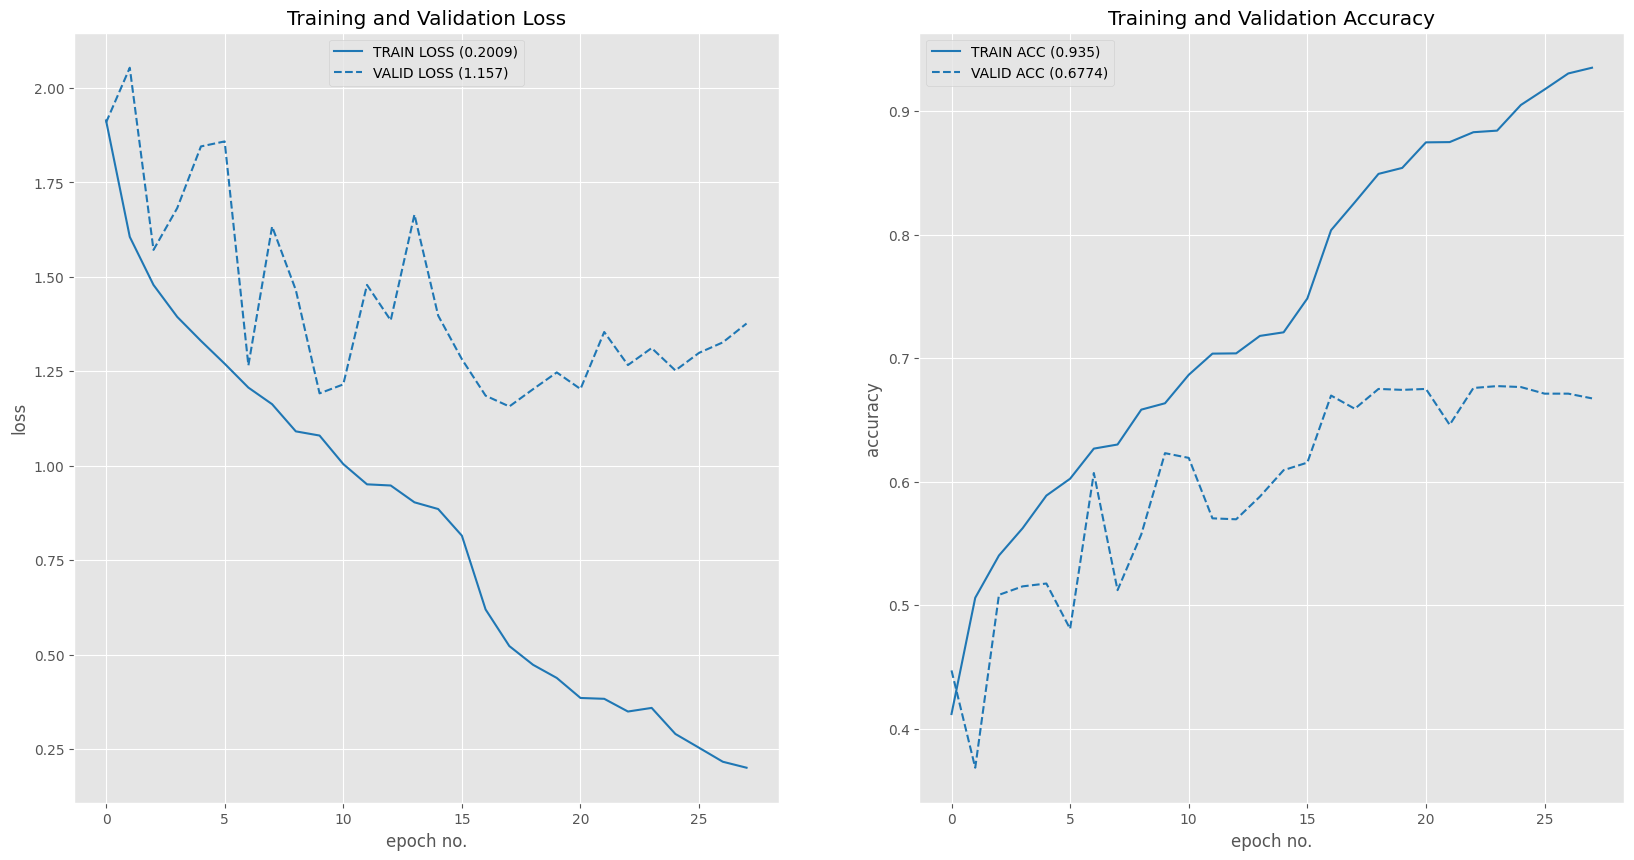

In [24]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

./validation


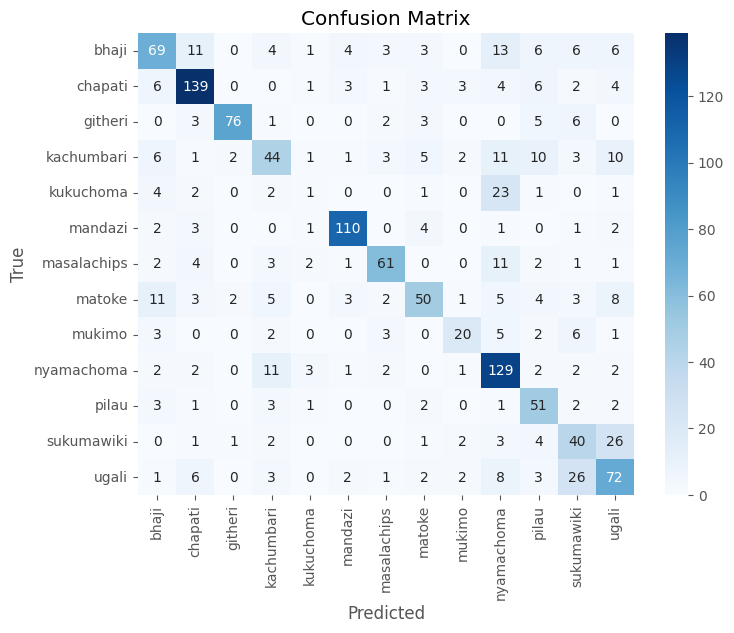

In [25]:
# m = pretrained_resnet18()
# m  = OptimizedResnet18()
m = CustomResNet()


model = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')
print(test_data_path)

mean, std = get_mean_std()
plot_confusion_matrix(model, data_root=test_data_path, mean=mean, std=std)

## <font style="color:green">8. TensorBoard Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


Note: In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

You are also welcome (and encouraged) to utilize alternative logging services like wandB or comet. In such instances, you can easily make your project logs publicly accessible and share the link with others.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

In [ ]:
from tqdm import tqdm

def predict_and_generate_submission(model_path, test_csv_path, images_dir, submission_csv_path, mean, std, batch_size=32):
    # Load the trained model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # model = pretrained_resnet18()  # Initialize the model architecture
    # model  = OptimizedResnet18()
    model = CustomResNet()

    model = load_model(model)  # Load the state dictionary
    model.to(device)
    model.eval()
    
    # Read the test.csv file
    test_df = pd.read_csv(test_csv_path)
    
    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust the size as needed
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    # Function to load and preprocess an image
    def load_image(image_id):
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        return transform(image)
    
    # List to store predictions
    predictions = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for image_id in tqdm(test_df['id'], desc="Processing images"):
            image = load_image(image_id)
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(image)
            pred = torch.argmax(output, dim=1).item()
            predictions.append(pred)
    
    # Map predictions to class names
    class_names = food_classes
    predicted_classes = [class_names[pred] for pred in predictions]
    
    # Create the submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'class': predicted_classes
    })
    
    # Save the submission DataFrame to a CSV file
    submission_df.to_csv(submission_csv_path, index=False)
    print(f"Submission file saved to {submission_csv_path}")

# Example usage
# model_path = 'models/final_kenyaFood_classifier.pt'
model_path = 'checkpoint.pt'
print(model_path)
test_csv_path = 'test.csv'
images_dir = 'images/images'
submission_csv_path = 'submission.csv'
mean, std = get_mean_std()

predict_and_generate_submission(model_path, test_csv_path, images_dir, submission_csv_path, mean, std)

checkpoint.pt


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing images: 100%|██████████| 1638/1638 [00:48<00:00, 34.06it/s]

Submission file saved to submission.csv


: 